## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re, nltk, spacy, string
import en_core_web_sm
from textblob import TextBlob
from nltk.corpus import brown


from wordcloud import WordCloud,STOPWORDS
from nltk.util import ngrams
import collections

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score,recall_score,precision_score,roc_auc_score

from gensim import corpora
from gensim.corpora import Dictionary
import gensim.downloader
from gensim import matutils, utils
from gensim.models import CoherenceModel, TfidfModel
from gensim.models.nmf import Nmf as Nmf

import os, time

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Setting display options

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.show_dimensions', False)
sns.set(color_codes=True)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json',)# Write the path to your data file and load it 
  
# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.shape

(78313, 22)

In [4]:
df.sample(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
56766,complaint-public-v2,complaint,1759299,0.000,None,60657,1759299,Excessive fees,2016-01-26T12:00:00-05:00,IL,No,Other financial service,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2016-02-01T12:00:00-05:00,None,Check cashing,Yes,,None,N/A
57566,complaint-public-v2,complaint,2876919,0.000,None,None,2876919,Managing an account,2018-04-16T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-04-16T12:00:00-05:00,None,Checking account,Yes,On XX/XX/2018 I deposited a cashiers check issued by XXXX XXXX XXXX in the amount of {$14000.00}...,Deposits and withdrawals,Consent provided
61066,complaint-public-v2,complaint,2380125,0.000,None,33324,2380125,Settlement process and costs,2017-03-10T12:00:00-05:00,FL,No,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-03-13T12:00:00-05:00,None,Home equity loan or line of credit,Yes,,None,Consent not provided
74426,complaint-public-v2,complaint,658349,0.000,None,77083,658349,Deposits and withdrawals,2014-01-07T12:00:00-05:00,TX,No,Bank account or service,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2014-01-08T12:00:00-05:00,None,Other bank product/service,Yes,,None,N/A
8495,complaint-public-v2,complaint,3318376,0.000,None,14580,3318376,Communication tactics,2019-07-25T12:00:00-05:00,NY,N/A,Debt collection,Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2019-07-25T12:00:00-05:00,None,Credit card debt,Yes,,Frequent or repeated calls,Consent not provided


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided'], dtype='object')

In [6]:
#Assign new column names
df.columns=['index', 'type', 'id', 'score', 'source', 'zip','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response', 'sub_product', 'timely','complaint_what_happened', 
        'sub_issue', 'consumer_consent_provided']

In [7]:
#Assign nan in place of blanks in the complaints column
df[df.complaint_what_happened==""]=np.nan

In [8]:
#Remove all rows where complaints column is nan
df=df[~df.complaint_what_happened.isnull()]

# Check sample data
df.sample(5)

,index,type,id,score,source,zip,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
40467,complaint-public-v2,complaint,2972271,0.000,Servicemember,100XX,2972271,Managing an account,2018-07-25T12:00:00-05:00,NY,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-07-25T12:00:00-05:00,None,Checking account,Yes,I recently opened up a Chase account approximately 2 weeks ago in New York. I have been having i...,Banking errors,Consent provided
41900,complaint-public-v2,complaint,1493422,0.000,Servicemember,906XX,1493422,"Loan modification,collection,foreclosure",2015-07-29T12:00:00-05:00,CA,No,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2015-07-29T12:00:00-05:00,None,Home equity loan or line of credit,Yes,"I, XXXX XXXX, have been trying to Modify my XXXX mortgage Thru Chase for the past XXXX years. Th...",None,Consent provided
77137,complaint-public-v2,complaint,3079381,0.000,None,113XX,3079381,Managing an account,2018-11-20T12:00:00-05:00,NY,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-11-27T12:00:00-05:00,None,Checking account,Yes,"On XX/XX/2018, I went to JP Morgan Chase to deposit {$6000.00} via ATM machine. However, the mac...",Deposits and withdrawals,Consent provided
72219,complaint-public-v2,complaint,1851143,0.000,None,600XX,1851143,Problems caused by my funds being low,2016-03-26T12:00:00-05:00,IL,Yes,Bank account or service,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-03-26T12:00:00-05:00,None,Checking account,Yes,Chase charged {$5000.00} in unneeded overdrafts things like charges going through twice can you ...,None,Consent provided
4025,complaint-public-v2,complaint,2764862,0.000,None,907XX,2764862,Incorrect information on your report,2017-12-27T12:00:00-05:00,CA,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2017-12-27T12:00:00-05:00,None,Credit reporting,Yes,"I have unauthorized "" INQUIRES '' on my credit report and I wrote to the creditor 's explaining ...",Information belongs to someone else,Consent provided


In [9]:
# Check shape
df.shape

(21072, 22)

#### 21072 rows abd 22 features for the preprocessing

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.

regex = re.compile('[%s]' % re.escape(string.punctuation))
def FormatComplaintText(txt) :
    txt = txt.lower() # convert to lower case
    txt = re.sub(r'\[.*?\]',"",txt) # remove text in between []
    txt = re.sub(r'[^\w\s]', "",txt) # remove punctuations
    txt = re.sub(r'\w*\d\w*',"",txt) # remove words containing numbers
    return(txt)

# Apply function to the complaint column
df["ComplaintCleaned"]=df.complaint_what_happened.apply(lambda x: FormatComplaintText(x))

# Check few smaples
df[["complaint_what_happened","ComplaintCleaned"]].head(5)

,complaint_what_happened,ComplaintCleaned
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card was reported on however fraudulent application have been submitted my identity witho...
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...


In [11]:
# load the nlp pipeline object
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

#Write your function to Lemmatize the texts
def ComplaintLemma(txt) :
    return (" ".join([word.lemma_ for word in nlp(txt)]))

# Applying lemmetize function to the ComplaintCleaned column
df["ComplaintLemma"]=df.ComplaintCleaned.apply(lambda x: ComplaintLemma(x))

#Printing Actual columns & Lemmatized text
df[["complaint_what_happened","ComplaintCleaned","ComplaintLemma"]]

,complaint_what_happened,ComplaintCleaned,ComplaintLemma
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit my identity without my c...
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...
...,...,...,...
78303,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday xxxxxxxx I call cha my xxxx xxxx visa credit card provider and ask how to make a cl...
78310,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...
78311,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...


In [12]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[["complaint_what_happened","ComplaintLemma"]]

In [13]:
df_clean

,complaint_what_happened,ComplaintLemma
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...
...,...,...
78303,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday xxxxxxxx I call cha my xxxx xxxx visa credit card provider and ask how to make a cl...
78310,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...
78311,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...


In [14]:
#Write your function to extract the POS tags 
def NP_chunk(txt):
    blob=TextBlob(txt)
    return(" ".join([word for (word,tag) in blob.tags if tag == "NN"]))

# Applying function to extract the Noun Phrases 
df_clean["complaint_POS_removed"]=df_clean["ComplaintLemma"].apply(lambda x: NP_chunk(x))

In [15]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
# check if any empty text
df_clean[df_clean.complaint_POS_removed ==""]["complaint_what_happened"].count()
df_clean=df_clean[df_clean.complaint_POS_removed !=""]

# Final dataframe
df_clean

,complaint_what_happened,ComplaintLemma,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx record...
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,card report application identity consent service credit identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,try book xxxx ticket offer ticket card information offer minute screen decision bank chase bank ...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund bank account pay money son check money bank refuse money son call chase t...
...,...,...,...
78303,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,card customer decade solicitation credit card chase airline mile hotel point card fee year month...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday xxxxxxxx I call cha my xxxx xxxx visa credit card provider and ask how to make a cl...,visa credit card provider claim purchase protection benefit xxxxxxxx school textbook year daught...
78310,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...,pay risk provide consumer bank app chase year mobile banking merchant merchant inquiry communica...
78311,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...,credit yrs credit card chase freedom xxxx problem balance transfer life plenty experience balanc...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘


In [16]:
# calculate length of complaint_POS_removed
df_clean["complaint_length"]=df_clean.complaint_POS_removed.apply(lambda x: len(x))

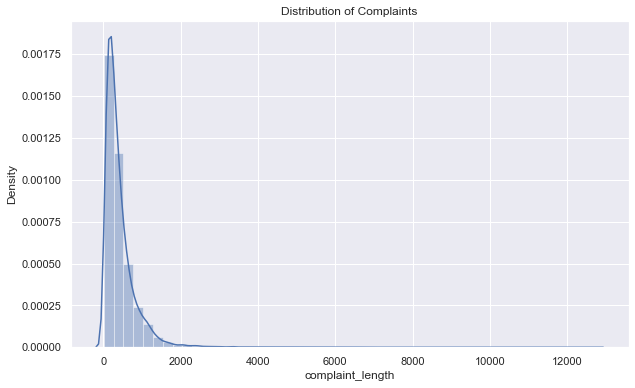

In [17]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
sns.distplot(df_clean["complaint_length"],bins=50)

plt.title("Distribution of Complaints")
plt.show()

#### We can see that distribution is positively skewed.

###### Find the top 40 words by frequency among all the articles after processing the text.

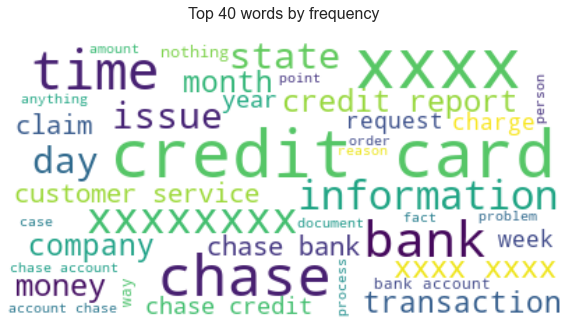

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

# corpus list
complaintPOSremoved =" ".join(df_clean["complaint_POS_removed"].to_list())

# Wordcount model
wc=WordCloud(stopwords=set(STOPWORDS),
             background_color="white",
             max_words=40,max_font_size=50,
             random_state=42).generate(complaintPOSremoved)

# Plot
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.title("Top 40 words by frequency \n", fontsize=16)
plt.show()

In [19]:
#Removing -PRON- from the text corpus

df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [20]:
# Finding unigrams,bigrams and trigrams 

def find_nGrams(gram) :
    
    # corpus list
    corpus =" ".join(df_clean["Complaint_clean"].to_list())

    # Remove stop words
    corpus=[word for word in corpus.split() if word not in set(STOPWORDS)]

    # gettig a list of all the ngrams
    nGrams = ngrams(corpus, gram)

    # getting the frequency of each ngram in our corpus
    nGramsFreq = collections.Counter(nGrams)
    
    return (nGramsFreq)

def plot_nGrams(nGrams,top_n,lbl) :

    # Plotting the top ngrams
    label=  [" ".join(list(i[0])) for i in nGrams.most_common(top_n)]
    freq=  [i[1] for i in nGrams.most_common(top_n)]

    plt.figure(figsize=(20,6))
    sns.barplot(label,freq) # graph
    plt.title("Top "+str(top_n)+" "+lbl+" and Frequencies",fontsize=18)
    plt.xlabel(lbl)
    plt.ylabel(lbl+" Frequency")
    plt.xticks(rotation='60')
    plt.show
    return;

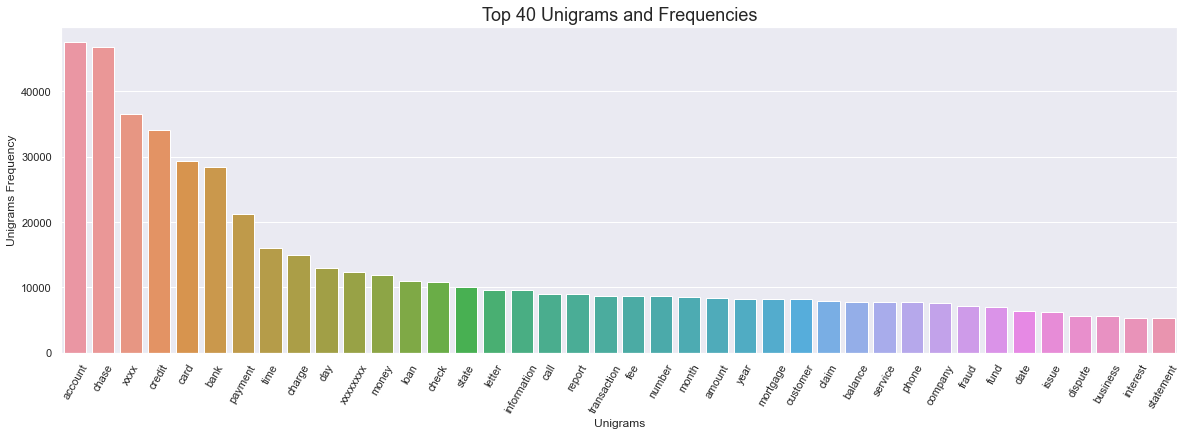

In [21]:
# Finding Top 40 Unigrams

plot_nGrams(find_nGrams(1),40,"Unigrams")

In [22]:
#Print the top 10 words in the unigram frequency

nGrams=find_nGrams(1)
Top_n =10
for label,freq in nGrams.most_common(Top_n) :
    print (" ".join(list(label))," - ", freq)

account  -  47497
chase  -  46730
xxxx  -  36545
credit  -  34129
card  -  29286
bank  -  28420
payment  -  21167
time  -  16055
charge  -  15004
day  -  12972


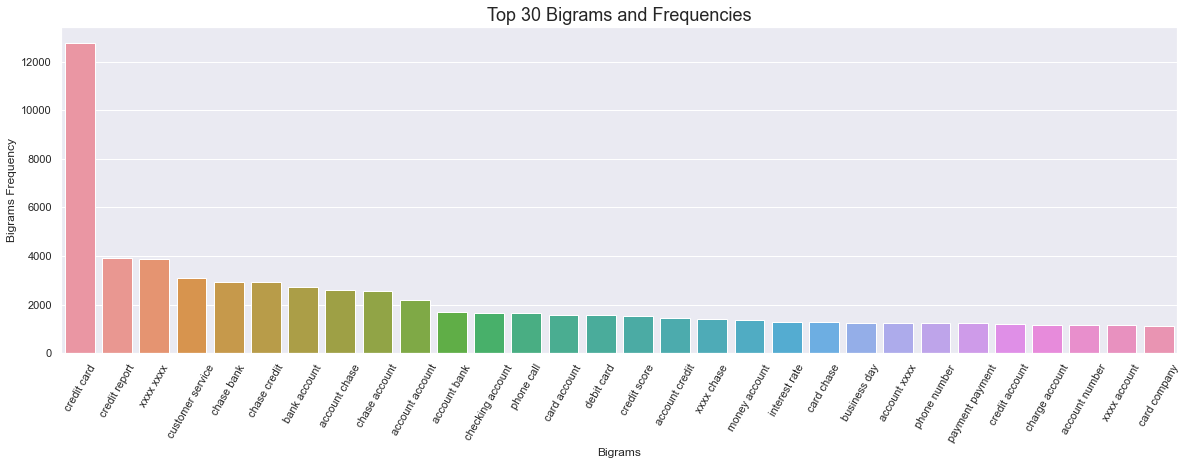

In [23]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

plot_nGrams(find_nGrams(2),30,"Bigrams")

In [24]:
#Print the top 10 words in the bigram frequency

nGrams=find_nGrams(2)
Top_n =10
for label,freq in nGrams.most_common(Top_n) :
    print (" ".join(list(label))," - ", freq)

credit card  -  12776
credit report  -  3927
xxxx xxxx  -  3868
customer service  -  3081
chase bank  -  2949
chase credit  -  2919
bank account  -  2729
account chase  -  2608
chase account  -  2566
account account  -  2191


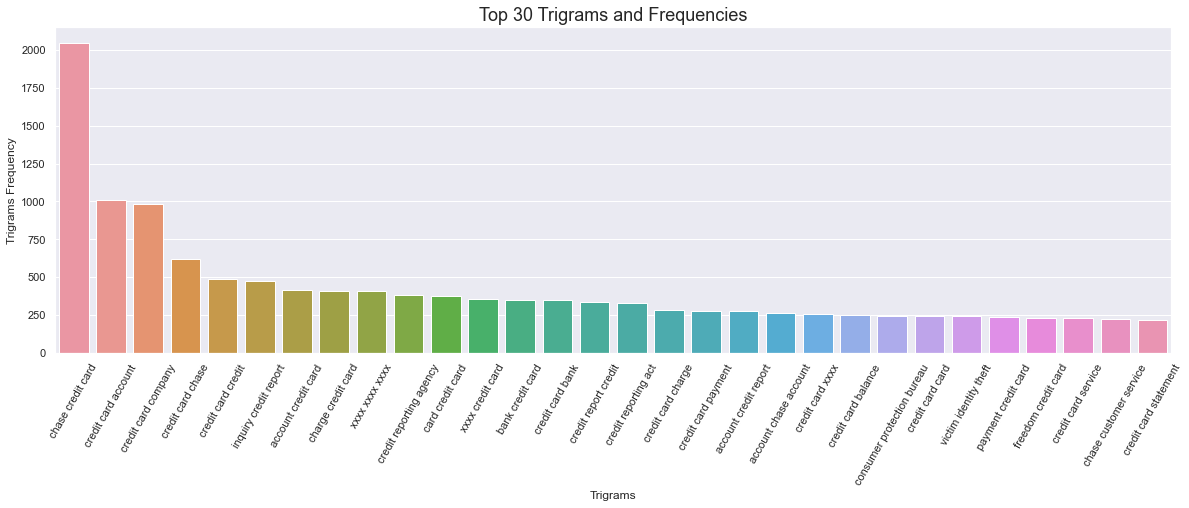

In [25]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
plot_nGrams(find_nGrams(3),30,"Trigrams")

In [26]:
#Print the top 10 words in the trigram frequency
nGrams=find_nGrams(3)
Top_n =10
for label,freq in nGrams.most_common(Top_n) :
    print (" ".join(list(label))," - ",freq)

chase credit card  -  2047
credit card account  -  1008
credit card company  -  984
credit card chase  -  620
credit card credit  -  486
inquiry credit report  -  478
account credit card  -  414
charge credit card  -  410
xxxx xxxx xxxx  -  409
credit reporting agency  -  383


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [27]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxx','').replace('xx','')

# corpus list
corpus =" ".join(df_clean["Complaint_clean"].to_list())

In [28]:
#All masked texts has been removed
df_clean

,complaint_what_happened,ComplaintLemma,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx record...,105,card agent upgrade date agent information order account change date consent recording agent
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,try book xxxx ticket offer ticket card information offer minute screen decision bank chase bank ...,414,try book ticket offer ticket card information offer minute screen decision bank chase bank noti...
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund bank account pay money son check money bank refuse money son call chase t...,161,son chase account fund bank account pay money son check money bank refuse money son call chase t...
...,...,...,...,...,...
78303,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,card customer decade solicitation credit card chase airline mile hotel point card fee year month...,213,card customer decade solicitation credit card chase airline mile hotel point card fee year month...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday xxxxxxxx I call cha my xxxx xxxx visa credit card provider and ask how to make a cl...,visa credit card provider claim purchase protection benefit xxxxxxxx school textbook year daught...,651,visa credit card provider claim purchase protection benefit school textbook year daughter schoo...
78310,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...,pay risk provide consumer bank app chase year mobile banking merchant merchant inquiry communica...,733,pay risk provide consumer bank app chase year mobile banking merchant merchant inquiry communica...
78311,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...,credit yrs credit card chase freedom xxxx problem balance transfer life plenty experience balanc...,494,credit yrs credit card chase freedom problem balance transfer life plenty experience balance tr...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [29]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english', ngram_range=(1,1))

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [30]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

# print Document Term Matrix
dtm

<21066x7253 sparse matrix of type '<class 'numpy.float64'>'
	with 644849 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

#### Coherence Model to find the best number of clusters

In [31]:
# We will be using Genesim NMF model to find the Coherence Score to decide on the No of Topics

# prepare dataset 
data=[text.split() for text in df_clean['Complaint_clean']]

# prepare genesim dictionary, corpus
gensim_dictionary = corpora.Dictionary(data)
gensim_dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)  # filter out too in/frequent tokens

# Creating bag of words model
gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in data]

# Initialize topic numbers, Scores list
topic_nos=list(np.arange(3,8,1))
coh_scores=[]

# NMF Model
for i in topic_nos :
    nmfmodel = Nmf(corpus=gensim_corpus,num_topics=i, id2word=gensim_dictionary,chunksize=3000,
              passes=10, eval_every=10, minimum_probability=0.01,random_state=40, kappa=0.1, normalize=True,
                  w_max_iter=300, w_stop_condition=0.0001,h_max_iter=100, h_stop_condition=0.001)

    # Coherences
    coh=CoherenceModel(model=nmfmodel, texts=data,dictionary=gensim_dictionary, coherence="c_v")
    coh_scores.append(round(coh.get_coherence(),5))

# Print Coherent Scores    
scores=list(zip(topic_nos,coh_scores))
scores

[(3, 0.38861), (4, 0.40762), (5, 0.41281), (6, 0.40448), (7, 0.39819)]

#### Best Coherence Score for No of Topics=5 is 0.41281 

In [32]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

#### In-view of trial and error aproach, let's check Topics using num_topics=4,5,6

In [33]:
# make a copy of the df_clean
df_clean_temp=df_clean.copy()

# No of clusters range 4-6
for i in range(4,7,1) :
    #initialize NMF model
    nmf_model = NMF(n_components=i, random_state=40)
    # Fitting the nmf model
    nmf_model.fit(dtm)

    #Create the best topic for each complaint in terms of integer values
    topics=nmf_model.transform(dtm)
    topics[0].argmax()
    topics.argmax(axis=1)
    # Assign topics
    df_clean_temp['Clusters_'+str(i)] = topics.argmax(axis=1)

df_clean_temp[["complaint_what_happened","Clusters_4","Clusters_5","Clusters_6"]].sample(15)

,complaint_what_happened,Clusters_4,Clusters_5,Clusters_6
62557,This complaint is against Chase Bank Credit Card. I always pay my balance in full ; last stateme...,1,1,1
32958,My bank account was closed with chase bank and I had deposited a check for {$47000.00} and it wa...,0,0,5
29386,"Our loan is currently serviced under JP Morgan Chase, as it was assumed XX/XX/XXXX. We started t...",2,4,4
7550,"To whom it may concern, over 6 months I have provide a notarized affidavit, police report, and l...",1,1,1
1632,Company - XXXX XX/XX/2017 received a bill for {$1.00} and XXXX Contacted Chase Credit Card dis...,3,3,3
71758,I attempted to pay off a mortgage loan with Chase. The loan number is XXXX. I sent XXXX personal...,0,0,5
32746,My Mortgage is serviced by XXXX XXXX XXXX Suposedly owned by XXXX XXXX XXXX XXXX as trustee For ...,2,4,4
41848,I paid XXXX on my Chase Freedom Card by accident about 6 months ago. I do my banking online and ...,1,1,0
61574,I purchased cruise tickets using my Chase card because of the built in travel insurance. After w...,3,3,3
5183,on XX/XX/20 I ordered a bottle of XXXX pills from an advertisement on my XXXX page. I accidenta...,3,3,3


#### We can see that Topics are properly grouped when No of Clusters=5, so we will go-ahead and build model with No of Topics=5

#### Building NMF model using No of Topics=5

In [34]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [35]:
# Fitting the nmf model
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7253

In [36]:
# Print Top 10 words from a sample topic
# Sample Topic No 4

topic=nmf_model.components_[4]
topwords=topic.argsort()[-10:]
for i in topwords :
    print(tfidf.get_feature_names()[i])

time
rate
letter
year
property
chase
modification
home
mortgage
loan


In [37]:
#Print the Top15 words for each of the topics

for idx, topic in enumerate(nmf_model.components_) :
    topwords=topic.argsort()[-15:]
    print("Top 15 words in Topic ",idx)
    print([tfidf.get_feature_names()[i] for i in topwords ])
    print()

Top 15 words in Topic  0
['transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']

Top 15 words in Topic  1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']

Top 15 words in Topic  2
['mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']

Top 15 words in Topic  3
['company', 'statement', 'refund', 'time', 'service', 'claim', 'fraud', 'purchase', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']

Top 15 words in Topic  4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']



In [38]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topics=nmf_model.transform(dtm)
topics[0].argmax()
topics.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2], dtype=int64)

In [39]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topics.argmax(axis=1) #write your code to assign topics to each rows.

In [40]:
df_clean.head()

,complaint_what_happened,ComplaintLemma,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx record...,105,card agent upgrade date agent information order account change date consent recording agent,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,1
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,try book xxxx ticket offer ticket card information offer minute screen decision bank chase bank ...,414,try book ticket offer ticket card information offer minute screen decision bank chase bank noti...,1
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund bank account pay money son check money bank refuse money son call chase t...,161,son chase account fund bank account pay money son check money bank refuse money son call chase t...,0


In [41]:
#Print the first 5 Complaint for each of the Topics

rows5=df_clean.groupby("Topic").head(5).sort_values("Topic")
rows5

,complaint_what_happened,ComplaintLemma,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...,0
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund bank account pay money son check money bank refuse money son call chase t...,161,son chase account fund bank account pay money son check money bank refuse money son call chase t...,0
17,With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On ...,with out notice jp morgan chase restrict my account by my debit card tuesday on thursday I g...,jp chase account debit card tuesday thursday branch customer service representative account bran...,623,jp chase account debit card tuesday thursday branch customer service representative account bran...,0
24,mishandling of this account by Chase auto and XXXX.,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,27,mishandle account auto,0
27,I opened an account with chase bank on XXXX and used a code for XXXX bonus. I called to follow u...,I open an account with chase bank on xxxx and use a code for xxxx bonus I call to follow up on x...,account bank code bonus term everything account deposit bonus day xxxx require deposit account c...,122,account bank code bonus term everything account deposit bonus day require deposit account coupo...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx record...,105,card agent upgrade date agent information order account change date consent recording agent,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,1
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,try book xxxx ticket offer ticket card information offer minute screen decision bank chase bank ...,414,try book ticket offer ticket card information offer minute screen decision bank chase bank noti...,1
15,Can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,1
23,I have a Chase credit card which is incorrectly reporting data on my credit report. The company ...,I have a chase credit card which be incorrectly report datum on my credit report the company be ...,chase credit card datum credit report company issue,51,chase credit card datum credit report company issue,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [42]:
#Create the dictionary of Topic names and Topics

Topics = {0: "Bank Account services", 1:"Credit card or prepaid card", 3:"Theft/Dispute Reporting",
               4: "Mortgage/Loan", 2: "Others"   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topics)

# make a copy of the df_clean dataframe
df_clean_copy=df_clean.copy()

In [43]:
df_clean

,complaint_what_happened,ComplaintLemma,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx record...,105,card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,try book xxxx ticket offer ticket card information offer minute screen decision bank chase bank ...,414,try book ticket offer ticket card information offer minute screen decision bank chase bank noti...,Credit card or prepaid card
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund bank account pay money son check money bank refuse money son call chase t...,161,son chase account fund bank account pay money son check money bank refuse money son call chase t...,Bank Account services
...,...,...,...,...,...,...
78303,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,card customer decade solicitation credit card chase airline mile hotel point card fee year month...,213,card customer decade solicitation credit card chase airline mile hotel point card fee year month...,Credit card or prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday xxxxxxxx I call cha my xxxx xxxx visa credit card provider and ask how to make a cl...,visa credit card provider claim purchase protection benefit xxxxxxxx school textbook year daught...,651,visa credit card provider claim purchase protection benefit school textbook year daughter schoo...,Theft/Dispute Reporting
78310,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...,pay risk provide consumer bank app chase year mobile banking merchant merchant inquiry communica...,733,pay risk provide consumer bank app chase year mobile banking merchant merchant inquiry communica...,Theft/Dispute Reporting
78311,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...,credit yrs credit card chase freedom xxxx problem balance transfer life plenty experience balanc...,494,credit yrs credit card chase freedom problem balance transfer life plenty experience balance tr...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [44]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services" :0, "Credit card or prepaid card" :1, "Theft/Dispute Reporting" :3,
               "Mortgage/Loan" :4, "Others" :2  }

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [45]:
df_clean

,complaint_what_happened,ComplaintLemma,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase ba...,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...,159,morning name stop bank cardmember service ask debt verification statement bank debt mail month d...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date...,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx record...,105,card agent upgrade date agent information order account change date consent recording agent,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",chase card be report on however fraudulent application have be submit my identity without my c...,card report application identity consent service credit identity applicant,74,card report application identity consent service credit identity applicant,1
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards t...,try book xxxx ticket offer ticket card information offer minute screen decision bank chase bank ...,414,try book ticket offer ticket card information offer minute screen decision bank chase bank noti...,1
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,my grand son give I check for I deposit it into my chase account after fund clear my chase ban...,son chase account fund bank account pay money son check money bank refuse money son call chase t...,161,son chase account fund bank account pay money son check money bank refuse money son call chase t...,0
...,...,...,...,...,...,...
78303,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,card customer decade solicitation credit card chase airline mile hotel point card fee year month...,213,card customer decade solicitation credit card chase airline mile hotel point card fee year month...,1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",on wednesday xxxxxxxx I call cha my xxxx xxxx visa credit card provider and ask how to make a cl...,visa credit card provider claim purchase protection benefit xxxxxxxx school textbook year daught...,651,visa credit card provider claim purchase protection benefit school textbook year daughter schoo...,3
78310,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,I be not familiar with xxxx pay and do not understand the great risk this provide to consumer I ...,pay risk provide consumer bank app chase year mobile banking merchant merchant inquiry communica...,733,pay risk provide consumer bank app chase year mobile banking merchant merchant inquiry communica...,3
78311,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",I have have flawless credit for yrs I ve have chase credit card chase freedom specifically...,credit yrs credit card chase freedom xxxx problem balance transfer life plenty experience balanc...,494,credit yrs credit card chase freedom problem balance transfer life plenty experience balance tr...,2


In [46]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data=df_clean[["complaint_what_happened","Topic"]]

In [47]:
training_data

,complaint_what_happened,Topic
1,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase B...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anni...,1
10,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my id...",1
11,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} t...",1
14,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my...,0
...,...,...
78303,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for...",1
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to...",3
78310,I am not familiar with XXXX pay and did not understand the great risk this provides to consumers...,3
78311,"I have had flawless credit for 30 yrs. I've had Chase credit cards, "" Chase Freedom '' specifica...",2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [48]:
#Write your code to get the Vector count

CntVector=CountVectorizer()
X_train_counts = CntVector.fit_transform(training_data["complaint_what_happened"])

#Write your code here to transform the word vector to tf-idf
tfidf_transform=TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_counts)                                     

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [49]:
# Write your code here to build any 3 models and evaluate them using the required metric

In [50]:
# Splitting the data into train and test

# Define X,y
X=X_train_tfidf
y=training_data.Topic 

# Splitting into Train,Test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

# Creating an empty dataframe to store metrics of each model
ML_scores=pd.DataFrame(columns=["Model","HyperParams","Accuracy","Recall","Precision","F1"])

### Logistic Regression

In [51]:
# Initiate and Fitting Logistic Regression

LR=LogisticRegression(random_state=42,solver='liblinear')
LR.fit(X_train, y_train)

# Predicting
y_pred=LR.predict(X_test)

# Create a dataframe
ytest_ypred = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
for i,j in zip(y_test,y_pred) :
    print(Topics.get(i) + " ------------- "+Topics.get(j))

Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reportin

Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Theft/Dispute Reporting


Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Others ------------- Others
Others ------------- Others
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Others ------------- Others
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Others ------------- Others
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Mort

In [52]:
# printing Metrics
confusion = confusion_matrix(y_test,y_pred)
print(confusion)
clreport=classification_report(y_test,y_pred,target_names=Topics.values())
print(clreport)

# Append the scores to dataframe
scores=["Logistic Regression","no",accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,average='macro'),
        precision_score(y_test,y_pred, average='macro'),f1_score(y_test,y_pred, average='macro')]
ML_scores.loc[len(ML_scores)]=scores

[[1462   25    2   40    7]
 [  26 1392    6   55   13]
 [  39   18  539   29   28]
 [  75   59   12 1281   21]
 [  31   30   14   14 1102]]
                             precision    recall  f1-score   support

      Bank Account services       0.90      0.95      0.92      1536
Credit card or prepaid card       0.91      0.93      0.92      1492
    Theft/Dispute Reporting       0.94      0.83      0.88       653
              Mortgage/Loan       0.90      0.88      0.89      1448
                     Others       0.94      0.93      0.93      1191

                   accuracy                           0.91      6320
                  macro avg       0.92      0.90      0.91      6320
               weighted avg       0.91      0.91      0.91      6320



#### We can see that good prescisin, recall, f1 scores. Let's see whether result can be improved aftre Hyperparameters tuning

### Logistic Regression - Hyperparameters Tuning

In [53]:
# Define params, GridSearch
params= { "C" : [100, 10, 1.0, 0.1, 0.01],"solver" : ['newton-cg', 'lbfgs', 'liblinear'],
         'penalty' : ['l1', 'l2']}

gs = GridSearchCV(estimator=LR, param_grid=params, cv = 5, n_jobs=-1, verbose=1, scoring="accuracy")

# Fitting the GridSearch
gs.fit(X_train,y_train)

#Printing Best Params & Score
print(gs.best_score_)
print(gs.best_estimator_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.1min finished


0.9371356909265423
LogisticRegression(penalty='l1', random_state=42, solver='liblinear')


In [54]:
# Fitting Logistic Regression with best params

LR=LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
LR.fit(X_train, y_train)

# Predicting
y_pred=LR.predict(X_test)

# printing Metrics
confusion = confusion_matrix(y_test,y_pred)
print(confusion)
clreport=classification_report(y_test,y_pred,target_names=Topics.values())
print(clreport)

# Append the scores to dataframe
scores=["Logistic Regression","yes",accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,average='macro'),
        precision_score(y_test,y_pred, average='macro'),f1_score(y_test,y_pred, average='macro')]
ML_scores.loc[len(ML_scores)]=scores

[[1472   17    6   34    7]
 [  15 1411    9   47   10]
 [  11   14  597   15   16]
 [  51   51   13 1315   18]
 [  22   17   12   14 1126]]
                             precision    recall  f1-score   support

      Bank Account services       0.94      0.96      0.95      1536
Credit card or prepaid card       0.93      0.95      0.94      1492
    Theft/Dispute Reporting       0.94      0.91      0.93       653
              Mortgage/Loan       0.92      0.91      0.92      1448
                     Others       0.96      0.95      0.95      1191

                   accuracy                           0.94      6320
                  macro avg       0.94      0.93      0.94      6320
               weighted avg       0.94      0.94      0.94      6320



#### We can see that metrics have been improved after the Hyperparameters Tuning and accuracy is about 94%

### Decision Tree

In [55]:
# Fitting Decision Tree classifier
DT = DecisionTreeClassifier(random_state=42, max_depth=5)
DT.fit(X_train, y_train)

# Predicting
y_pred=DT.predict(X_test)

# Print predictions
for i,j in zip(y_test,y_pred) :
    print(Topics.get(i) + " ------------- "+Topics.get(j))

Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Bank Account services
Theft/Dispute Reporting ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Bank Account services
Mortgage/Loan ------------- Others
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting -------------

Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Bank Account services
Credit card or prepaid card ------------- Bank Account services
Theft/Dispute Reporting ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Bank Account services
Mortgage/Loan ----------

Others ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Others ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Bank Account

Bank Account services ------------- Bank Account services
Others ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Bank Account services
Others ------------- Others
Bank Account services ------------- Bank Account services
Others ------------- Ot

Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Theft/Dispute Reporting
Bank Account services ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Others ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Others ------------- Credit card or prepaid card
Others ------------- Bank Account services
Others ------------- Others
Mortgage/Loan ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account servic

In [56]:
# printing Metrics
confusion = confusion_matrix(y_test,y_pred)
print(confusion)
clreport=classification_report(y_test,y_pred,target_names=Topics.values())
print(clreport)

# Append the scores to dataframe
scores=["Decision Tree Classifier","no",accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,average='macro'),
        precision_score(y_test,y_pred, average='macro'),f1_score(y_test,y_pred, average='macro')]
ML_scores.loc[len(ML_scores)]=scores

[[1349   36   17  120   14]
 [ 162  979   24  303   24]
 [ 126   31  421   31   44]
 [ 493   38   32  875   10]
 [ 431   24   41   27  668]]
                             precision    recall  f1-score   support

      Bank Account services       0.53      0.88      0.66      1536
Credit card or prepaid card       0.88      0.66      0.75      1492
    Theft/Dispute Reporting       0.79      0.64      0.71       653
              Mortgage/Loan       0.65      0.60      0.62      1448
                     Others       0.88      0.56      0.68      1191

                   accuracy                           0.68      6320
                  macro avg       0.74      0.67      0.69      6320
               weighted avg       0.73      0.68      0.68      6320



#### - We can see that accuracy has come down drastically. Let's see if it imporoves after tuning the Hyper parameters

### Decision Tree - Hyperparameters Tuning

In [57]:
# Estimating params
params = {'max_depth': [25,50,75,100,150], 'min_samples_leaf': [5,10,20,50,100], 'criterion': ["gini", "entropy"]}

# Defining GridSearch
gs = GridSearchCV(estimator=DT, param_grid=params, cv = 5, n_jobs=-1, verbose=1, scoring="accuracy")

#Fitting Gridsearch
gs.fit(X_train, y_train)

#Printing Best Params & Score
print(gs.best_score_)
print(gs.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.5min finished


0.7880783718698094
DecisionTreeClassifier(max_depth=25, min_samples_leaf=10, random_state=42)


In [58]:
# Fitting the Decision Tree Classifier with Best Params

DT=DecisionTreeClassifier(max_depth=25, min_samples_leaf=10, random_state=42).fit(X_train, y_train)

# Predicting
y_pred=DT.predict(X_test)

# printing Metrics
confusion = confusion_matrix(y_test,y_pred)
print(confusion)
clreport=classification_report(y_test,y_pred,target_names=Topics.values())
print(clreport)

# Appending to scores dataframe
scores=["Decision Tree Classifier","yes",accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,average='macro'),
        precision_score(y_test,y_pred, average='macro'),f1_score(y_test,y_pred, average='macro')]
ML_scores.loc[len(ML_scores)]=scores

[[1268   51   31  122   64]
 [  69 1217   18  140   48]
 [  37   39  483   36   58]
 [ 134  127   33 1066   88]
 [  60   34   72   39  986]]
                             precision    recall  f1-score   support

      Bank Account services       0.81      0.83      0.82      1536
Credit card or prepaid card       0.83      0.82      0.82      1492
    Theft/Dispute Reporting       0.76      0.74      0.75       653
              Mortgage/Loan       0.76      0.74      0.75      1448
                     Others       0.79      0.83      0.81      1191

                   accuracy                           0.79      6320
                  macro avg       0.79      0.79      0.79      6320
               weighted avg       0.79      0.79      0.79      6320



#### - Metrics have been improved after Hyperparameters tuning, but still not as good as LR

### Random Forest Classifier

In [59]:
# Initialize & Fitting Decision Tree classifier
RF = RandomForestClassifier(random_state=42, n_jobs=-1)
RF.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [60]:
# Predicting
y_pred=RF.predict(X_test)

# Printing predictions
for i,j in zip(y_test,y_pred) :
    print(Topics.get(i) + " ------------- "+Topics.get(j))    

Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Credit car

Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Theft/Disp

Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Others ------------- Others
Credit card or prepaid card ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Others ------------- Others
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Others ------------- Others
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Theft/Dispute Report

In [61]:
# printing Metrics
confusion = confusion_matrix(y_test,y_pred)
print(confusion)
clreport=classification_report(y_test,y_pred,target_names=Topics.values())
print(clreport)

# Appending to scores dataframe
scores=["Random Forest Classifier","no",accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,average='macro'),
        precision_score(y_test,y_pred, average='macro'),f1_score(y_test,y_pred, average='macro')]
ML_scores.loc[len(ML_scores)]=scores

[[1406   60    3   52   15]
 [  57 1313    5  106   11]
 [ 114   80  295   67   97]
 [ 177  100    8 1147   16]
 [  70   69   11   25 1016]]
                             precision    recall  f1-score   support

      Bank Account services       0.77      0.92      0.84      1536
Credit card or prepaid card       0.81      0.88      0.84      1492
    Theft/Dispute Reporting       0.92      0.45      0.61       653
              Mortgage/Loan       0.82      0.79      0.81      1448
                     Others       0.88      0.85      0.87      1191

                   accuracy                           0.82      6320
                  macro avg       0.84      0.78      0.79      6320
               weighted avg       0.83      0.82      0.81      6320



#### - We can see model metrics are not as good as LR or DT. Let's see if it will improve after Hyper parameters tuning

### Random Forest - Hyperparameter Tuning

In [62]:
# Estimating params
params = {'max_depth': [25,50,75,100,150], 'min_samples_leaf': [5,10,20,50,100], 'n_estimators': [10, 25, 50, 100]}

# Defining GridSearch
gs = GridSearchCV(estimator=RF, param_grid=params, cv = 5, n_jobs=-1, verbose=1, scoring="accuracy")

#Fitting Gridsearch
gs.fit(X_train, y_train)

# Printing best Hyperparameters and Best Accuracy score
print(gs.best_score_)
rf_best = gs.best_estimator_
rf_best

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished


0.798046864492991


RandomForestClassifier(max_depth=75, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [63]:
# Initialize & Fitting our Topics with Best Params
RF = RandomForestClassifier(max_depth=75, min_samples_leaf=5, n_jobs=-1,random_state=42).fit(X_train, y_train)

# Predicting
y_pred=RF.predict(X_test)

# printing Metrics
confusion = confusion_matrix(y_test,y_pred)
print(confusion)
clreport=classification_report(y_test,y_pred,target_names=Topics.values())
print(clreport)

# Appending to scores dataframe
scores=["Random Forest Classifier","yes",accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,average='macro'),
        precision_score(y_test,y_pred, average='macro'),f1_score(y_test,y_pred, average='macro')]
ML_scores.loc[len(ML_scores)]=scores


[[1405   75    0   44   12]
 [  62 1299    1  122    8]
 [ 122  121  202   84  124]
 [ 186  101    6 1136   19]
 [  60   99    6   18 1008]]
                             precision    recall  f1-score   support

      Bank Account services       0.77      0.91      0.83      1536
Credit card or prepaid card       0.77      0.87      0.82      1492
    Theft/Dispute Reporting       0.94      0.31      0.47       653
              Mortgage/Loan       0.81      0.78      0.80      1448
                     Others       0.86      0.85      0.85      1191

                   accuracy                           0.80      6320
                  macro avg       0.83      0.75      0.75      6320
               weighted avg       0.81      0.80      0.79      6320



#### - Metrics have not improved and also slightly overfitting tendency for Theft/Dispute Reporting category

### Multi Nomial Naive Bayes Model

In [64]:
# Initilialize & Fitting the Multinomial Naive Bayes Model
NB = MultinomialNB()
NB.fit(X_train, y_train)

# Predicting
y_pred=NB.predict(X_test)

# Create a dataframe
for i,j in zip(y_test,y_pred) :
    print(Topics.get(i) + " ------------- "+Topics.get(j))

Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Bank Account services
Bank Account services ------------- Credit card or prepaid card
Mortgage/Loan ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Bank Account services
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Credit car

Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Bank Account services
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Others ------------- Theft/Dispute Reporting
Others ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Others ------------- Bank Acco

Credit card or prepaid card ------------- Bank Account services
Credit card or prepaid card ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Others ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Theft/Dispute Reporting
Others ------------- Bank Account services
Mortgage/Loan --------

Theft/Dispute Reporting ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Bank Account services
Mortgage/Loan ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Bank Account services
Others ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or pr

Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------

Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Others ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Ac

Credit card or prepaid card ------------- Theft/Dispute Reporting
Others ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Others ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services


Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Others ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Others ------------- Credit card or prepaid card
Mortgage/Loan ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank

Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Others ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Others ------------- Theft/Dispute Reporting
Others ------------- Others
Bank Account services --------

Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Bank Account services
Credit card or prepaid card ------------- Bank Account services
Bank Account services ------------- Bank Account services
Others ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Bank Account services
Bank Account services ------------- Bank Account services
Bank Account services ------------- Bank Account services
Others ------------- Credit card or prepaid card


Others ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Others ------------- Others
Others ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Credit card or prepaid card
Mortgage/Loan ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Others ------------- Bank Account services
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Bank Account services
Credit card or prepaid card ------------- Theft/Dispute Reporting
Others ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Mortgage/Loan ------------- Mortgage/Loan
Credit car

Mortgage/Loan ------------- Mortgage/Loan
Credit card or prepaid card ------------- Credit card or prepaid card
Theft/Dispute Reporting ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Credit card or prepaid card
Bank Account services ------------- Bank Account services
Bank Account services ------------- Credit card or prepaid card
Credit card or prepaid card ------------- Credit card or prepaid card
Others ------------- Theft/Dispute Reporting
Credit card or prepaid card ------------- Theft/Dispute Reporting
Bank Account services ------------- Bank Account services
Credit card or prepaid card ------------- Credit card or prepaid card
Others ------------- Credit card or prepaid card
Mortgage/Loan ------------- Mortgage/Loan
Bank Account services ------------- Bank Account services
Bank Account services ------------- Credit card or prepaid card
Mortgage/Loan ------------- Bank Account services
Mortgage/Loan ------------- Mortgage/Loan
Others -------------

In [65]:
# printing Metrics
confusion = confusion_matrix(y_test,y_pred)
print(confusion)
clreport=classification_report(y_test,y_pred,target_names=Topics.values())
print(clreport)

# Appending to scores dataframe
scores=["MultiNomial Naive Bayes","no",accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,average='macro'),
        precision_score(y_test,y_pred, average='macro'),f1_score(y_test,y_pred, average='macro')]
ML_scores.loc[len(ML_scores)]=scores

[[1416   74    0   44    2]
 [ 166 1150    0  169    7]
 [ 228  215    7  116   87]
 [ 305   72    0 1067    4]
 [ 193  132    0   22  844]]
                             precision    recall  f1-score   support

      Bank Account services       0.61      0.92      0.74      1536
Credit card or prepaid card       0.70      0.77      0.73      1492
    Theft/Dispute Reporting       1.00      0.01      0.02       653
              Mortgage/Loan       0.75      0.74      0.74      1448
                     Others       0.89      0.71      0.79      1191

                   accuracy                           0.71      6320
                  macro avg       0.79      0.63      0.61      6320
               weighted avg       0.76      0.71      0.67      6320



#### - We can see that Theft/Dispute Reporting category has been highly overfitted. Let's see if it can improve after Hyperparameters Tuning

### Multi Nomial Naive Bayes - Hyperparameters Tuning

In [66]:
# Selecting params (alpha)
params = {'alpha':[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]        }

# Defining GridSearch & Fitting
gs = GridSearchCV(estimator=NB, param_grid=params, cv = 5, n_jobs=-1, verbose=1, scoring="accuracy").fit(X_train,y_train)

# Printing best Params
print(gs.best_score_)
print(gs.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.7734983303734101
MultinomialNB(alpha=0.05)


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished


In [67]:
# Fitting with Hyperparams Naive Bayes Model
NB = MultinomialNB(alpha=0.05)
NB.fit(X_train, y_train)

# Predicting
y_pred=NB.predict(X_test)

# printing Metrics
confusion = confusion_matrix(y_test,y_pred)
print(confusion)
clreport=classification_report(y_test,y_pred,target_names=Topics.values())
print(clreport)

# Appending to scores dataframe
scores=["Multi Nomial Naive Bayes","yes",accuracy_score(y_test,y_pred),recall_score(y_test,y_pred,average='macro'),
        precision_score(y_test,y_pred, average='macro'),f1_score(y_test,y_pred, average='macro')]
ML_scores.loc[len(ML_scores)]=scores


[[1285  112   10   94   35]
 [  96 1168   28  164   36]
 [  92   89  321   72   79]
 [ 199   89   26 1114   20]
 [  68   77   48   18  980]]
                             precision    recall  f1-score   support

      Bank Account services       0.74      0.84      0.78      1536
Credit card or prepaid card       0.76      0.78      0.77      1492
    Theft/Dispute Reporting       0.74      0.49      0.59       653
              Mortgage/Loan       0.76      0.77      0.77      1448
                     Others       0.85      0.82      0.84      1191

                   accuracy                           0.77      6320
                  macro avg       0.77      0.74      0.75      6320
               weighted avg       0.77      0.77      0.77      6320



#### - We can see that metrics have been improved a lot, after the Hyperparameters tuning, However, model accuracy is too low when compared with LR

In [68]:
# Print the final metrics to compare

ML_scores

,Model,HyperParams,Accuracy,Recall,Precision,F1
0,Logistic Regression,no,0.914,0.904,0.919,0.910
1,Logistic Regression,yes,0.937,0.934,0.938,0.936
2,Decision Tree Classifier,no,0.679,0.669,0.744,0.686
3,Decision Tree Classifier,yes,0.794,0.789,0.790,0.789
4,Random Forest Classifier,no,0.819,0.778,0.839,0.792
5,Random Forest Classifier,yes,0.799,0.745,0.828,0.753
6,MultiNomial Naive Bayes,no,0.709,0.630,0.792,0.605
7,Multi Nomial Naive Bayes,yes,0.770,0.741,0.771,0.750


#### Best Model
- Based on the metrics the model that performs best is Logistic Regression. So we will choose logistic regression among all the models

### Test the best model with a random sentence

In [69]:
# Let's test one random sentence using the best model "Logistic Regression"

text=["My card loan has been completed last month, but still installment has been deducted. Please credit the amount immediately"]

# Transform text to Countvectorizer, TFIDF matrix
text_counts = CntVector.transform(text)
text_tfidf = tfidf_transform.transform(text_counts)

# Predicting using the model Logistic Regression
text_pred = LR.predict(text_tfidf)

# print the Topic
print(Topics.get(text_pred[0]))

Credit card or prepaid card
